In [1]:

import matplotlib as mpl
mpl.use('Agg')
import os
import h5py
import json
import re
import sys
import datetime
import optparse
import pprint
import cPickle as pkl
import tifffile as tf
import pylab as pl
import numpy as np
from scipy import ndimage
import cv2
import glob
from scipy.optimize import curve_fit
import seaborn as sns
from pipeline.python.retinotopy import visualize_rois as vis
from matplotlib.patches import Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy as sp
import pandas as pd

from pipeline.python.utils import natural_keys, label_figure, replace_root
from pipeline.python.retinotopy import visualize_rois as visroi
from pipeline.python.retinotopy import do_retinotopy_analysis as ra

pp = pprint.PrettyPrinter(indent=4)
from scipy.signal import argrelextrema


In [2]:
%matplotlib notebook

In [3]:

def extract_options(options):
    
    parser = optparse.OptionParser()

    parser.add_option('-D', '--root', action='store', dest='rootdir', default='/n/coxfs01/2p-data', help='data root dir (root project dir containing all animalids) [default: /nas/volume1/2photon/data, /n/coxfs01/2pdata if --slurm]')
    parser.add_option('-i', '--animalid', action='store', dest='animalid', default='', help='Animal ID')

    # Set specific session/run for current animal:
    parser.add_option('-S', '--session', action='store', dest='session', default='', \
                      help='session dir (format: YYYMMDD_ANIMALID')
    parser.add_option('-A', '--acq', action='store', dest='acquisition', default='FOV1', \
                      help="acquisition folder (ex: 'FOV1_zoom3x') [default: FOV1]")
    parser.add_option('-R', '--run', action='store', dest='run', default='retino_run1', \
                      help="name of run dir containing tiffs to be processed (ex: gratings_phasemod_run1)")
    parser.add_option('-t', '--retinoid', action='store', dest='retinoid', default='analysis001', \
                      help="name of retino ID (roi analysis) [default: analysis001]")
    
    parser.add_option('--angular', action='store_false', dest='use_linear', default=True, \
                      help="Plot az/el coordinates in angular spce [default: plots linear coords]")
#     parser.add_option('-e', '--thr-el', action='store', dest='fit_thresh_el', default=0.2, \
#                       help="fit threshold for elevation [default: 0.2]")
#     parser.add_option('-a', '--thr-az', action='store', dest='fit_thresh_az', default=0.2, \
#                       help="fit threshold for azimuth [default: 0.2]")
    
    (options, args) = parser.parse_args(options)

    return options

In [4]:
def load_retino_analysis_info(animalid, session, fov, run, retinoid, use_pixels=False, rootdir='/n/coxfs01/2p-data'):
    
    run_dir = glob.glob(os.path.join(rootdir, animalid, session, '%s*' % fov, run))[0]
    fov = os.path.split(os.path.split(run_dir)[0])[-1]
    print("FOV: %s, run: %s" % (fov, run))
    retinoids_fpath = glob.glob(os.path.join(run_dir, 'retino_analysis', 'analysisids_*.json'))[0]
    with open(retinoids_fpath, 'r') as f:
        rids = json.load(f)
    if use_pixels:
        roi_analyses = [r for r, rinfo in rids.items() if rinfo['PARAMS']['roi_type'] == 'pixels']
    else:
        roi_analyses = [r for r, rinfo in rids.items() if rinfo['PARAMS']['roi_type'] != 'pixels']
    if retinoid not in roi_analyses:
        retinoid = sorted(roi_analyses, key=natural_keys)[-1] # use most recent roi analysis
        print("Fixed retino id to most recent: %s" % retinoid)
        
    return retinoid, rids[retinoid]


In [5]:
def get_retino_stimulus_info(mwinfo, runinfo):
    
    stiminfo = dict((cond, dict()) for cond in conditions)
    for curr_cond in conditions:
        # get some info from paradigm and run file
        stimfreq = np.unique([v['stimuli']['scale'] for k,v in mwinfo.items() if v['stimuli']['stimulus']==curr_cond])[0]
        stimperiod = 1./stimfreq # sec per cycle
        
        n_frames = runinfo['nvolumes']
        fr = runinfo['frame_rate']
        
        n_cycles = int(round((n_frames/fr) / stimperiod))
        print n_cycles

        n_frames_per_cycle = int(np.floor(stimperiod * fr))
        cycle_starts = np.round(np.arange(0, n_frames_per_cycle * n_cycles, n_frames_per_cycle)).astype('int')

        stiminfo[curr_cond] = {'stimfreq': stimfreq,
                               'frame_rate': fr,
                               'n_reps': len(trials_by_cond[curr_cond]),
                               'nframes': n_frames,
                               'n_cycles': n_cycles,
                               'n_frames_per_cycle': n_frames_per_cycle,
                               'cycle_start_ixs': cycle_starts
                              }

    return stiminfo

# Select data set

In [6]:
options = ['-i', 'JC047', '-S', '20190215', '-A', 'FOV1']

In [7]:
opts = extract_options(options)

rootdir = opts.rootdir
animalid = opts.animalid
session = opts.session
fov = opts.acquisition
run = opts.run
retinoid = opts.retinoid
use_linear = opts.use_linear
#fit_thresh_az = float(opts.fit_thresh_az)
#fit_thresh_el = float(opts.fit_thresh_el) #0.2


# Load data

In [8]:
# Select which retino analysis to use:
use_pixels = False
retinoid, rinfo = load_retino_analysis_info(animalid, session, fov, run, retinoid, 
                                            use_pixels=use_pixels, rootdir=rootdir)

# Create data identifier for figures:
data_identifier = '|'.join([animalid, session, fov, run, retinoid])
print("*** Dataset: %s ***" % data_identifier)

# Get processed retino data:
run_dir = glob.glob(os.path.join(rootdir, animalid, session, '%s*' % fov, run))[0]
processed_dir = glob.glob(os.path.join(run_dir, 'retino_analysis', '%s*' % retinoid))[0]
processed_fpaths = glob.glob(os.path.join(processed_dir, 'files', '*.h5'))
print("Found %i processed retino runs." % len(processed_fpaths))

# Get condition info for trials:
conditions_fpath = glob.glob(os.path.join(run_dir, 'paradigm', 'files', '*.json'))[0]
with open(conditions_fpath, 'r') as f:
    mwinfo = json.load(f)
conditions = list(set([cdict['stimuli']['stimulus'] for trial_num, cdict in mwinfo.items()]))
trials_by_cond = dict((cond, [int(k) for k, v in mwinfo.items() if v['stimuli']['stimulus']==cond]) \
                      for cond in conditions)

# Get run info:
runinfo_fpath = glob.glob(os.path.join(run_dir, '*.json'))[0]
with open(runinfo_fpath, 'r') as f:
    runinfo = json.load(f)
print trials_by_cond

# Get stimulus info:
stiminfo = get_retino_stimulus_info(mwinfo, runinfo)
stiminfo['trials_by_cond'] = trials_by_cond

# Load raw traces -- Use 'processed' (np-corrected + preprocessing)
extracted_traces_fpath = glob.glob(os.path.join(processed_dir, 'traces', '*.h5'))[0]
traces = h5py.File(extracted_traces_fpath)
print traces.keys()
print traces[traces.keys()[0]].keys()


FOV: FOV1_zoom4p0x, run: retino_run1
Fixed retino id to most recent: analysis002
*** Dataset: JC047|20190215|FOV1|retino_run1|analysis002 ***
Found 12 processed retino runs.
{u'top': [11, 5, 6], u'right': [1, 4, 8], u'left': [10, 2, 7], u'bottom': [12, 3, 9]}
12
12
12
12
[u'File001', u'File002', u'File003', u'File004', u'File005', u'File006', u'File007', u'File008', u'File009', u'File010', u'File011', u'File012']
[u'corrected', u'masks', u'neuropil', u'np_masks', u'processed', u'raw']


# Set output dir

In [9]:
output_dir = os.path.join(processed_dir, 'visualization', 'rf_estimates')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Get stimulus info

In [10]:
def get_parsed_cycles(rid, traces, stiminfo, chunksize=1):

    
    parsed_traces = dict()
    parsed_cycle_ixs = dict()
    for curr_cond, trial_nums in stiminfo['trials_by_cond'].items():
        ncycles = stiminfo[curr_cond]['n_cycles']
        resampled = ncycles/chunksize
        
        fr_per_cycle = stiminfo[curr_cond]['n_frames_per_cycle'] * chunksize
        cycle_starts = stiminfo[curr_cond]['cycle_start_ixs'][0::chunksize]
        ntrials = len(trials_by_cond[curr_cond])

        roi_cycles = []
        for trial in trial_nums:

            roi_trace = traces['File%03d' % trial]['processed'][rid, :]

            nparsed_cycles = len(cycle_starts) # ncycles/resampled #chunksize
            ptraces = np.zeros((nparsed_cycles, fr_per_cycle))
            for cycle in np.arange(0, nparsed_cycles):
                ixs_to_fill = cycle_starts[cycle] + fr_per_cycle
                if ixs_to_fill > len(roi_trace):
                    roi_trace = np.pad(roi_trace, ((0, ixs_to_fill - len(roi_trace))),\
                                       mode='constant', constant_values=0)
                ptraces[cycle, :] = roi_trace[cycle_starts[cycle]:(cycle_starts[cycle]+fr_per_cycle)]

            roi_cycles.append(ptraces)
        
        parsed_traces[curr_cond] = np.array(roi_cycles)
        parsed_cycle_ixs[curr_cond] = [s/chunksize for s in cycle_starts]
        
    return parsed_traces, parsed_cycle_ixs

# Parse cycles of each condition

In [11]:
c1 = 'right'
c2 = 'left'
c1_color = 'blue'
c2_color = 'orange'


### Look at 1 ROI first

In [12]:
rid = 27

roi_traces = np.array([traces['File%03d' % f]['processed'][rid, :] for f in trials_by_cond[c1]])
print roi_traces.shape

(3, 4125)


<IPython.core.display.Javascript object>


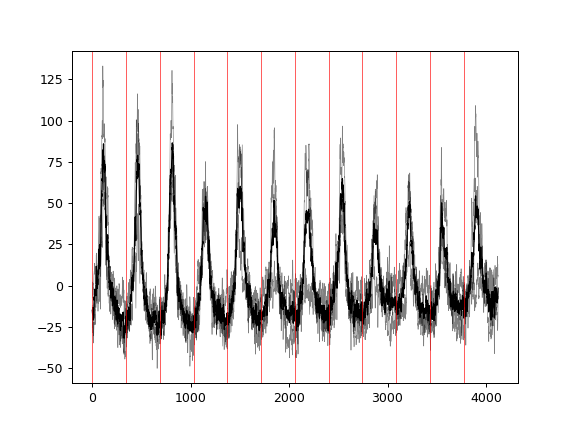

In [13]:

pl.figure()
for tr in np.arange(0, roi_traces.shape[0]):
    pl.plot(roi_traces[tr,:], 'k', lw=0.5, alpha=0.5)
    
pl.plot(roi_traces.mean(axis=0), 'k', lw=1, alpha=1)
    
for cyc in stiminfo[c1]['cycle_start_ixs']:
    pl.axvline(x=cyc, color='r', lw=0.5)

### Get average N cycles

In [14]:
chunksize = 1
parsed_traces, parsed_cycle_ixs = get_parsed_cycles(rid, traces, stiminfo, chunksize=chunksize)


<IPython.core.display.Javascript object>


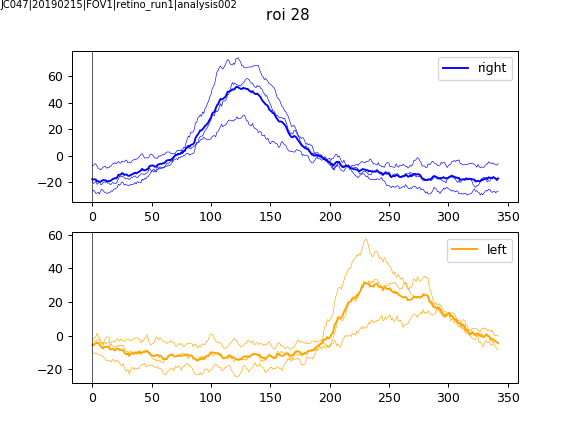

In [15]:

fig, axes = pl.subplots(2,1)

# nreps, ncycles, nframes_per = parsed_traces[curr_cond].shape

ax = axes[0]
for rep in np.arange(stiminfo[c1]['n_reps']):
    ax.plot(parsed_traces[c1][rep,:,:].mean(axis=0), c1_color, lw=0.5)
    
ax.plot(parsed_traces[c1].mean(axis=1).mean(axis=0), c1_color, label=c1)
ax.legend()
for cyc in parsed_cycle_ixs[c1][0:chunksize]:
    ax.axvline(x=cyc, color='k', lw=0.5)
    
ax = axes[1]
for rep in np.arange(stiminfo[c2]['n_reps']):
    ax.plot(parsed_traces[c2][rep,:,:].mean(axis=0), c2_color, lw=0.5)
ax.plot(parsed_traces[c2].mean(axis=1).mean(axis=0), c2_color, label=c2)
ax.legend()

for cyc in parsed_cycle_ixs[c2][0:chunksize]:
    ax.axvline(x=cyc, color='k', lw=0.5)
    
pl.suptitle('roi %i' % int(rid+1))
label_figure(fig, data_identifier)

figname = 'averaged_%i_cycle_by_run_roi%05d_%s_%s' % (chunksize, int(rid+1), c1, c2)
pl.savefig(os.path.join(output_dir, '%s.png' % figname))


# Get bar positions from MW

In [18]:
# Interpolate bar position for found SI frame using upsampled MW tstamps and positions:


def get_interp_positions(condname, mwinfo, stiminfo, trials_by_cond):
    mw_fps = 1./np.diff(np.array(mwinfo[str(trials_by_cond[condname][0])]['stiminfo']['tstamps'])/1E6).mean()
    si_fps = stiminfo[condname]['frame_rate']
    print "[%s]: Downsampling MW positions (sampled at %.2fHz) to SI frame rate (%.2fHz)" % (condname, mw_fps, si_fps)

    si_cyc_ixs = stiminfo[condname]['cycle_start_ixs']
    si_tstamps = runinfo['frame_tstamps_sec']


    #fig, axes = pl.subplots(1, len(trials_by_cond[condname]))

    stim_pos_list = []
    stim_tstamp_list = []

    for ti, trial in enumerate(trials_by_cond[condname]):
        #ax = axes[ti]

        pos_list = []
        tstamp_list = []
        mw_cyc_ixs = mwinfo[str(trial)]['stiminfo']['start_indices']
        for cix in np.arange(0, len(mw_cyc_ixs)):
            if cix==len(mw_cyc_ixs)-1:
                mw_ts = [t/1E6 for t in mwinfo[str(trial)]['stiminfo']['tstamps'][mw_cyc_ixs[cix]:]]
                xs = mwinfo[str(trial)]['stiminfo']['values'][mw_cyc_ixs[cix]:]
                si_ts = si_tstamps[si_cyc_ixs[cix]:]
            else:
                mw_ts = np.array([t/1E6 for t in mwinfo[str(trial)]['stiminfo']['tstamps'][mw_cyc_ixs[cix]:mw_cyc_ixs[cix+1]]])
                xs = np.array(mwinfo[str(trial)]['stiminfo']['values'][mw_cyc_ixs[cix]:mw_cyc_ixs[cix+1]])
                si_ts = si_tstamps[si_cyc_ixs[cix]:si_cyc_ixs[cix+1]]

            recentered_mw_ts = [t-mw_ts[0] for t in mw_ts]
            recentered_si_ts = [t-si_ts[0] for t in si_ts]

            # Since MW tstamps are linear, SI tstamps linear, interpolate position values down to SI's lower framerate:
            interpos = sp.interpolate.interp1d(recentered_mw_ts, xs, fill_value='extrapolate')
            resampled_xs = interpos(recentered_si_ts)

            pos_list.append(pd.Series(resampled_xs, name=trial))
            tstamp_list.append(pd.Series(recentered_si_ts, name=trial))

            #ax.plot(recentered_mw_ts, xs, 'ro', alpha=0.5, markersize=2)
            #ax.plot(recentered_si_ts, resampled_xs, 'bx', alpha=0.5, markersize=2)

        pos_vals = pd.concat(pos_list, axis=0).reset_index(drop=True) 
        tstamp_vals = pd.concat(tstamp_list, axis=0).reset_index(drop=True)

        stim_pos_list.append(pos_vals)
        stim_tstamp_list.append(tstamp_vals)

    stim_positions = pd.concat(stim_pos_list, axis=1)
    stim_tstamps = pd.concat(stim_tstamp_list, axis=1)


    return stim_positions, stim_tstamps


In [19]:
stim_positions1, stim_tstamps1 = get_interp_positions(c1, mwinfo, stiminfo, trials_by_cond)
stim_positions2, stim_tstamps2 = get_interp_positions(c2, mwinfo, stiminfo, trials_by_cond)

[right]: Downsampling MW positions (sampled at 59.81Hz) to SI frame rate (44.63Hz)
[left]: Downsampling MW positions (sampled at 59.81Hz) to SI frame rate (44.63Hz)


# Identify max, min, and "onset" frame in averaged trace

In [25]:
def get_cycle_onsets(avg_cycle_c1, cycle_starts, fr_per_cyc, baseline_window_size=10., nstds_above_baseline=1.5):

    # Find peaks for each cycle:
    cmaxima = []
    cminima = []
    onsets = []
    baseline_values= []
    baseline_indices = []
    
    # Get max, min, and "onset" for each cycle in "mini" roi-trace:
    for cyc_ix, cyc_start in enumerate(cycle_starts):

        curr_frames = np.arange(cyc_start, cyc_start+fr_per_cyc)
        curr_values = avg_cycle_c1[curr_frames]
        cmax = int(np.where(curr_values==curr_values.max())[0][0])
        cmaxima.append((curr_frames[cmax], curr_values.max()))

        minval = curr_values[0:cmax].min()
        cmin = int(np.where(curr_values[0:cmax]==minval)[0][0])
        cminima.append((curr_frames[cmin], minval))

        baseline = curr_values[cmin-baseline_window_size:cmin+baseline_window_size]
        bindices = curr_frames[cmin-baseline_window_size:cmin+baseline_window_size]
        if cmin-baseline_window_size < 0: # include frames from previous "cycle" since likely at very edge
            if cyc_ix == 0:
                # No previous cycle to borrow frames from
                bindices = curr_frames[0:cmin+baseline_window_size]
                baseline = curr_values[0:cmin+baseline_window_size]
            else:
                prev_frames = np.arange(cycle_starts[cyc_ix-1], cycle_starts[cyc_ix-1]+fr_per_cyc)
                prev_values = avg_cycle_c1[prev_frames]
                nprev = baseline_window_size-cmin
                bindices = curr_frames[0:cmin+baseline_window_size]
                bindices = sorted(np.append(bindices, prev_frames[-nprev:]))

                baseline = prev_values[-nprev:]
                baseline = np.append(baseline, curr_values[0:cmin+baseline_window_size])

        thr_value = baseline.std() * nstds_above_baseline #curr_values.max()*0.1
        onset = np.where(np.abs(curr_values[0:cmax]-thr_value)==np.min(np.abs(curr_values[0:cmax]-thr_value)))[0]

        onsets.append((curr_frames[onset], curr_values[onset]))
        baseline_values.append(baseline)
        baseline_indices.append(bindices)
        
    return cmaxima, cminima, onsets, (baseline_indices, baseline_values)



In [26]:
def plot_cycle_loci(avg_cycle_c1, cycle_starts, cmax, cmin, onsets, bas_ixs, bas_vals):

    fig, ax = pl.subplots(figsize=(6,3)) #pl.figure()

    ax.plot(avg_cycle_c1)
    for cyc in cycle_starts:
        ax.axvline(x=cyc, color='k', lw=0.5)

    for c in cmax:
        ax.plot(c[0], c[1], 'r.')

    for c in cmin:
        ax.plot(c[0], c[1], 'b.')

    for ons in onsets:
        if not ons[0].size:
            continue
        ax.plot(ons[0], ons[1], 'g.')

    for bi, bv in zip(bas_ixs, bas_vals):
        ax.plot(bi, bv, 'k')

### Plot averaged mini-trace, with key loci

<IPython.core.display.Javascript object>


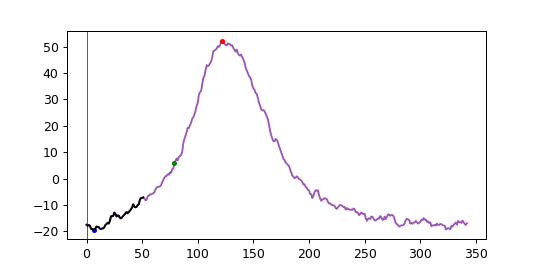

<IPython.core.display.Javascript object>


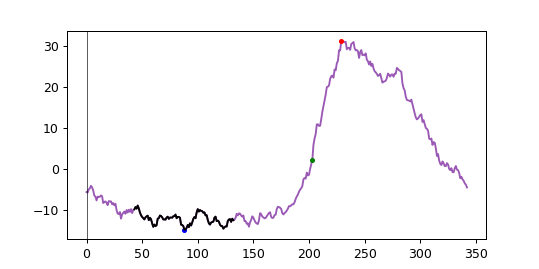

In [28]:
nstds_above_baseline = 1.5
window_nsecs = 1.

avg_cycle_c1 = parsed_traces[c1].mean(axis=1).mean(axis=0)
cycle_starts = parsed_cycle_ixs[c1][0:chunksize]
fr_per_cyc = stiminfo[c1]['n_frames_per_cycle'] 
baseline_window_size = int(round(stiminfo[c1]['frame_rate']*window_nsecs))
cmax1, cmin1, onsets1, (bas_ixs1, bas_vals1) = get_cycle_onsets(avg_cycle_c1, cycle_starts, fr_per_cyc,
                                                             baseline_window_size=baseline_window_size, 
                                                             nstds_above_baseline=nstds_above_baseline)

plot_cycle_loci(avg_cycle_c1, cycle_starts, cmax1, cmin1, onsets1, bas_ixs1, bas_vals1)

avg_cycle_c2 = parsed_traces[c2].mean(axis=1).mean(axis=0)
cycle_starts = parsed_cycle_ixs[c2][0:chunksize]
fr_per_cyc = stiminfo[c2]['n_frames_per_cycle'] 
windowsize = int(round(stiminfo[c2]['frame_rate']*window_nsecs))
cmax2, cmin2, onsets2, (bas_ixs2, bas_vals2) = get_cycle_onsets(avg_cycle_c2, cycle_starts, fr_per_cyc,
                                                             baseline_window_size=baseline_window_size, 
                                                             nstds_above_baseline=nstds_above_baseline)                                                     

plot_cycle_loci(avg_cycle_c2, cycle_starts, cmax2, cmin2, onsets2, bas_ixs2, bas_vals2)


# Use interp stim positions to get bar position at onset

In [29]:
print onsets1
print onsets2

[(array([79]), array([ 5.88756592]))]
[(array([203]), array([ 2.30822723]))]


In [30]:
stim_positions1.head()

,1,4,8
0,43.715256,43.715256,43.715256
1,43.593553,43.433791,43.598055
2,43.340381,43.176024,43.338851
3,43.063791,42.909187,43.062905
4,42.800143,42.645830,42.799943


In [31]:
mean_pos_vals1 = stim_positions1.mean(axis=1)
avg_pos_list = []
cycle_starts = parsed_cycle_ixs[c1][0::chunksize]
for cix, cyc in enumerate(cycle_starts):
    if cix == len(cycle_starts)-1:
        avg_pos_list.append(mean_pos_vals1[cyc:])
    else:
        avg_pos_list.append(mean_pos_vals1[cyc:cycle_starts[cix+1]])
    
for ai, a in enumerate(avg_pos_list):
    avg_pos_list[ai] = a[0:stiminfo[c1]['n_frames_per_cycle']]
avg_positions1 = np.vstack(avg_pos_list).mean(axis=0)



mean_pos_vals2 = stim_positions2.mean(axis=1)
avg_pos_list = []
cycle_starts = parsed_cycle_ixs[c2][0::chunksize]
for cix, cyc in enumerate(cycle_starts):
    if cix == len(cycle_starts)-1:
        avg_pos_list.append(mean_pos_vals2[cyc:])
    else:
        avg_pos_list.append(mean_pos_vals2[cyc:cycle_starts[cix+1]])
    
for ai, a in enumerate(avg_pos_list):
    avg_pos_list[ai] = a[0:stiminfo[c2]['n_frames_per_cycle']]
avg_positions2 = np.vstack(avg_pos_list).mean(axis=0)



In [32]:
onset_positions1 = []
onset_positions2 = []
for onset, cyc in zip(onsets1, np.arange(0, len(onsets1))):
    onset_positions1.append(float(avg_positions1[onset[0]]))
                           
onset_positions2 = []
for onset, cyc in zip(onsets2, np.arange(0, len(onsets2))):
    onset_positions2.append(float(avg_positions2[onset[0]]))
    
onset_pos1 = np.mean(onset_positions1)
onset_pos2 = np.mean(onset_positions2)

print "%s: onset %.2f" % (c1, onset_pos1)
print "%s: onset %.2f" % (c2, onset_pos2)

                           


right: onset 22.64
left: onset 10.45
